# Prophet 모델 이용하여 일별 취급액, 판매량 예측

 Facebook Prophet 모델을 이용해 일별 취급액, 판매량을 예측해 본다. LSTM 모델의 전반적인 성능과 비교하기 위함이다.
 
 - 취급액 합계 : standard scaling 진행.
 - 판매량 합계 : scaling 없이 진행.

# 결과
 주기성은 잘 잡아내는 듯하나, holiday effects 등이 반영이 안 되는 듯하다. 해당하는 주기 안에서만 움직인다. LSTM 모델보다는 나은 듯. scaling 여부는 크게 영향이 없는 듯하다.

In [1]:
# 모듈 불러오기
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

from fbprophet import Prophet

In [2]:
# 그래프 출력 설정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
import matplotlib.font_manager as fm

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()

NanumGothic Eco


In [3]:
# 경로 변경
os.chdir('/content/drive/My Drive/Big-Contest')
os.getcwd()

'/content/drive/My Drive/Big-Contest'

In [4]:
# 경로 설정
RAW_DATA = './data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx'

In [5]:
# 데이터 로드 및 기본 전처리
data_raw = pd.read_excel(RAW_DATA, header=1)
data = data_raw[data_raw['상품군'] != '무형'] # 무형 상품군 제외
data['노출(분)'] = data['노출(분)'].fillna(method='ffill') # 노출 결측치 처리
data['취급액'] = data['취급액'].fillna(0) # 취급액 0원인 상품 처리
data = data[data['방송일시'].dt.year != 2020] # 2020년 데이터 제외
data = data.reset_index(drop=True)

In [6]:
# 판매량 컬럼 생성
data['판매량'] = data['취급액'] / data['판매단가']

In [7]:
# 집계 기준 컬럼 생성
data['날짜'] = data['방송일시'].dt.date
data['날짜시간'] = data['방송일시'].dt.floor('H')
data['날짜'] = pd.to_datetime(data['날짜'])
data['날짜시간'] = pd.to_datetime(data['날짜시간'])
data.head(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,날짜,날짜시간
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000.0,52.606516,2019-01-01,2019-01-01 06:00:00
1,2019-01-01 06:00:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000.0,109.548872,2019-01-01,2019-01-01 06:00:00
2,2019-01-01 06:20:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000.0,81.754386,2019-01-01,2019-01-01 06:00:00
3,2019-01-01 06:20:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000.0,174.310777,2019-01-01,2019-01-01 06:00:00
4,2019-01-01 06:40:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000.0,167.218045,2019-01-01,2019-01-01 06:00:00
5,2019-01-01 06:40:00,20.0,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000.0,234.010025,2019-01-01,2019-01-01 06:00:00
6,2019-01-01 07:00:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000.0,115.576271,2019-01-01,2019-01-01 07:00:00
7,2019-01-01 07:20:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000.0,265.915254,2019-01-01,2019-01-01 07:00:00
8,2019-01-01 07:40:00,20.0,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000.0,430.000000,2019-01-01,2019-01-01 07:00:00
9,2019-01-01 08:00:00,20.0,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,16133000.0,269.332220,2019-01-01,2019-01-01 08:00:00


## 일별 취급액 합계

In [8]:
# 일별 취급액 합계 표준화
daily = pd.DataFrame(data.groupby(by='날짜', as_index=False)['취급액'].sum())
scaler = StandardScaler()
scaler.fit(daily[['취급액']])
daily['취급액_scaled'] = scaler.transform(daily[['취급액']])
daily = daily.set_index('날짜', drop=True)
daily

,날짜,취급액,취급액_scaled
0,2019-01-01,2.712779e+09,1.441322
1,2019-01-02,2.011023e+09,-0.692183
2,2019-01-03,2.062043e+09,-0.537070
3,2019-01-04,2.049394e+09,-0.575526
4,2019-01-05,2.588390e+09,1.063150
...,...,...,...
360,2019-12-27,2.378887e+09,0.426211
361,2019-12-28,2.706958e+09,1.423624
362,2019-12-29,2.706806e+09,1.423162
363,2019-12-30,2.224920e+09,-0.041886


In [11]:
# 트레인 테스트 셋 분리
df_train = daily[daily['날짜'].dt.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
df_test = daily[daily['날짜'].dt.month.isin([11, 12])]
display(df_train)
display(df_test)

,날짜,취급액,취급액_scaled
0,2019-01-01,2.712779e+09,1.441322
1,2019-01-02,2.011023e+09,-0.692183
2,2019-01-03,2.062043e+09,-0.537070
3,2019-01-04,2.049394e+09,-0.575526
4,2019-01-05,2.588390e+09,1.063150
...,...,...,...
299,2019-10-27,2.404899e+09,0.505293
300,2019-10-28,2.177307e+09,-0.186640
301,2019-10-29,2.277165e+09,0.116952
302,2019-10-30,2.148788e+09,-0.273345


,날짜,취급액,취급액_scaled
304,2019-11-01,1.923839e+09,-0.957243
305,2019-11-02,2.368083e+09,0.393364
306,2019-11-03,2.368254e+09,0.393884
307,2019-11-04,2.335232e+09,0.293489
308,2019-11-05,2.204104e+09,-0.105171
...,...,...,...
360,2019-12-27,2.378887e+09,0.426211
361,2019-12-28,2.706958e+09,1.423624
362,2019-12-29,2.706806e+09,1.423162
363,2019-12-30,2.224920e+09,-0.041886


In [14]:
# Prophet 모델에 맞게 데이터셋 구성
train = df_train[['날짜', '취급액_scaled']].rename(columns={'날짜':'ds', '취급액_scaled':'y'})
train

,ds,y
0,2019-01-01,1.441322
1,2019-01-02,-0.692183
2,2019-01-03,-0.537070
3,2019-01-04,-0.575526
4,2019-01-05,1.063150
...,...,...
299,2019-10-27,0.505293
300,2019-10-28,-0.186640
301,2019-10-29,0.116952
302,2019-10-30,-0.273345


In [15]:
# prophet 모델 훈련
m = Prophet()
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
# 예측
test = df_test[['날짜']].rename(columns={'날짜':'ds'})
forecast = m.predict(test)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-01,0.002594,-1.490240,0.443550,0.002594,0.002594,-0.548015,-0.548015,-0.548015,-0.548015,-0.548015,-0.548015,0.0,0.0,0.0,-0.545421
1,2019-11-02,0.003697,-0.447788,1.395486,0.003697,0.003697,0.479917,0.479917,0.479917,0.479917,0.479917,0.479917,0.0,0.0,0.0,0.483615
2,2019-11-03,0.004800,0.158950,1.985997,0.004800,0.004800,1.079395,1.079395,1.079395,1.079395,1.079395,1.079395,0.0,0.0,0.0,1.084195
3,2019-11-04,0.005903,-1.271364,0.565222,0.005902,0.005905,-0.333939,-0.333939,-0.333939,-0.333939,-0.333939,-0.333939,0.0,0.0,0.0,-0.328035
4,2019-11-05,0.007007,-1.146429,0.682721,0.007003,0.007011,-0.244035,-0.244035,-0.244035,-0.244035,-0.244035,-0.244035,0.0,0.0,0.0,-0.237028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2019-12-27,0.064372,-1.423818,0.481394,0.064001,0.064791,-0.548015,-0.548015,-0.548015,-0.548015,-0.548015,-0.548015,0.0,0.0,0.0,-0.483642
57,2019-12-28,0.065476,-0.424969,1.507292,0.065091,0.065903,0.479917,0.479917,0.479917,0.479917,0.479917,0.479917,0.0,0.0,0.0,0.545393
58,2019-12-29,0.066579,0.293587,2.067856,0.066181,0.067015,1.079395,1.079395,1.079395,1.079395,1.079395,1.079395,0.0,0.0,0.0,1.145973
59,2019-12-30,0.067682,-1.227406,0.669083,0.067272,0.068127,-0.333939,-0.333939,-0.333939,-0.333939,-0.333939,-0.333939,0.0,0.0,0.0,-0.266257


In [29]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
daily['취급액_scaled_예측'] = forecast['yhat']
daily['취급액_scaled_lower'] = forecast['yhat_lower']
daily['취급액_scaled_upper'] = forecast['yhat_upper']
daily

,취급액,취급액_scaled,취급액_scaled_예측,취급액_scaled_lower,취급액_scaled_upper
날짜,,,,,
2019-01-01,2.712779e+09,1.441322,NaN,NaN,NaN
2019-01-02,2.011023e+09,-0.692183,NaN,NaN,NaN
2019-01-03,2.062043e+09,-0.537070,NaN,NaN,NaN
2019-01-04,2.049394e+09,-0.575526,NaN,NaN,NaN
2019-01-05,2.588390e+09,1.063150,NaN,NaN,NaN
...,...,...,...,...,...
2019-12-27,2.378887e+09,0.426211,-0.483642,-1.423818,0.481394
2019-12-28,2.706958e+09,1.423624,0.545393,-0.424969,1.507292
2019-12-29,2.706806e+09,1.423162,1.145973,0.293587,2.067856


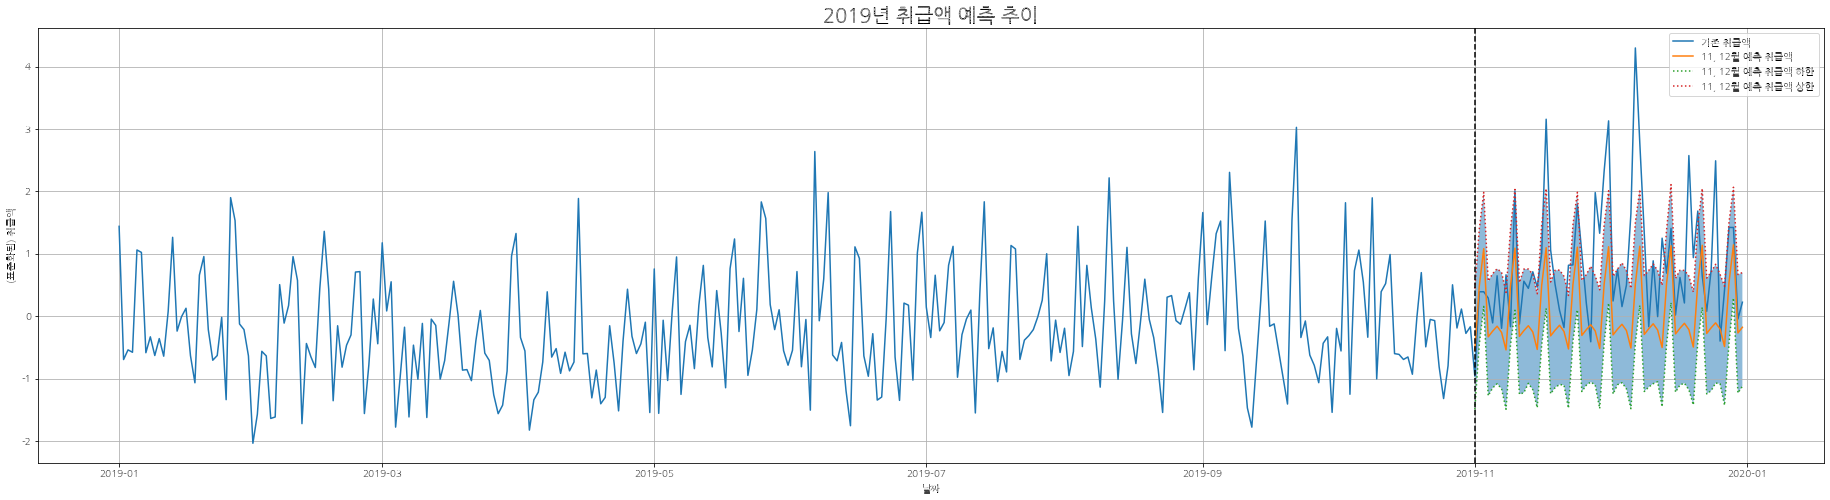

In [44]:
# 시각화
plt.figure(figsize=(32, 8))
plt.plot(daily['취급액_scaled'], label='기존 취급액')
plt.plot(daily['취급액_scaled_예측'], label='11, 12월 예측 취급액')
plt.plot(daily['취급액_scaled_lower'], linestyle='dotted', label='11, 12월 예측 취급액 하한')
plt.plot(daily['취급액_scaled_upper'], linestyle='dotted', label='11, 12월 예측 취급액 상한')
plt.fill_between(daily.index, daily['취급액_scaled_lower'], daily['취급액_scaled_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-11-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('(표준화된) 취급액')
plt.title('2019년 취급액 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()

## 일별 판매량

In [10]:
# 일별 판매량 합계
daily = pd.DataFrame(data.groupby(by='날짜', as_index=True)['판매량'].sum())
# scaler = StandardScaler()
# scaler.fit(daily[['취급액']])
# daily['취급액_scaled'] = scaler.transform(daily[['취급액']])
daily

,판매량
날짜,
2019-01-01,36326.952820
2019-01-02,28589.281389
2019-01-03,27534.941901
2019-01-04,30233.381266
2019-01-05,32935.714225
...,...
2019-12-27,38497.527750
2019-12-28,41862.657133
2019-12-29,37007.953870


In [12]:
# 트레인 테스트 셋 분리
df_train = daily[daily.index.month.isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])]
df_test = daily[daily.index.month.isin([11, 12])]
display(df_train)
display(df_test)

,판매량
날짜,
2019-01-01,36326.952820
2019-01-02,28589.281389
2019-01-03,27534.941901
2019-01-04,30233.381266
2019-01-05,32935.714225
...,...
2019-10-27,39310.429995
2019-10-28,38406.283673
2019-10-29,35374.082930


,판매량
날짜,
2019-11-01,28019.010004
2019-11-02,29467.827793
2019-11-03,30406.009717
2019-11-04,38397.515100
2019-11-05,28337.180294
...,...
2019-12-27,38497.527750
2019-12-28,41862.657133
2019-12-29,37007.953870


In [16]:
# Prophet 모델에 맞게 데이터셋 구성
train = df_train.reset_index(drop=False).rename(columns={'날짜':'ds', '판매량':'y'})
test = df_test.reset_index(drop=False)[['날짜']].rename(columns={'날짜':'ds'})
display(train)
display(test)

,ds,y
0,2019-01-01,36326.952820
1,2019-01-02,28589.281389
2,2019-01-03,27534.941901
3,2019-01-04,30233.381266
4,2019-01-05,32935.714225
...,...,...
299,2019-10-27,39310.429995
300,2019-10-28,38406.283673
301,2019-10-29,35374.082930
302,2019-10-30,29421.159234


,ds
0,2019-11-01
1,2019-11-02
2,2019-11-03
3,2019-11-04
4,2019-11-05
...,...
56,2019-12-27
57,2019-12-28
58,2019-12-29
59,2019-12-30


In [18]:
# prophet 모델 훈련 및 예측
m = Prophet()
m.fit(train)
forecast = m.predict(test)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-01,33896.162711,24302.777017,37945.306352,33896.162711,33896.162711,-2941.523301,-2941.523301,-2941.523301,-2941.523301,-2941.523301,-2941.523301,0.0,0.0,0.0,30954.639410
1,2019-11-02,33929.367712,28558.387761,42586.349338,33929.367712,33929.367712,1555.619012,1555.619012,1555.619012,1555.619012,1555.619012,1555.619012,0.0,0.0,0.0,35484.986725
2,2019-11-03,33962.572713,29523.251597,43299.154379,33962.535343,33962.572713,2419.854207,2419.854207,2419.854207,2419.854207,2419.854207,2419.854207,0.0,0.0,0.0,36382.426921
3,2019-11-04,33995.777714,26639.783088,40007.522129,33994.801796,33996.133985,-648.737420,-648.737420,-648.737420,-648.737420,-648.737420,-648.737420,0.0,0.0,0.0,33347.040294
4,2019-11-05,34028.982715,28113.620366,41645.879279,34026.807419,34030.092275,601.791601,601.791601,601.791601,601.791601,601.791601,601.791601,0.0,0.0,0.0,34630.774317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2019-12-27,35755.642765,26065.433085,39538.224670,35480.325614,36014.885827,-2941.523301,-2941.523301,-2941.523301,-2941.523301,-2941.523301,-2941.523301,0.0,0.0,0.0,32814.119464
57,2019-12-28,35788.847766,30374.318420,43904.108668,35505.455767,36051.168273,1555.619012,1555.619012,1555.619012,1555.619012,1555.619012,1555.619012,0.0,0.0,0.0,37344.466778
58,2019-12-29,35822.052766,31096.672740,45094.896368,35531.123279,36092.893334,2419.854207,2419.854207,2419.854207,2419.854207,2419.854207,2419.854207,0.0,0.0,0.0,38241.906974
59,2019-12-30,35855.257767,28591.145649,42248.016048,35558.832257,36133.255640,-648.737420,-648.737420,-648.737420,-648.737420,-648.737420,-648.737420,0.0,0.0,0.0,35206.520348


In [19]:
# daily df에 합치기
forecast = forecast.set_index('ds', drop=True) # 인덱스 설정
daily['판매량_예측_pred'] = forecast['yhat']
daily['판매량_예측_lower'] = forecast['yhat_lower']
daily['판매량_예측_upper'] = forecast['yhat_upper']
daily

,판매량,판매량_예측_pred,판매량_예측_lower,판매량_예측_upper
날짜,,,,
2019-01-01,36326.952820,NaN,NaN,NaN
2019-01-02,28589.281389,NaN,NaN,NaN
2019-01-03,27534.941901,NaN,NaN,NaN
2019-01-04,30233.381266,NaN,NaN,NaN
2019-01-05,32935.714225,NaN,NaN,NaN
...,...,...,...,...
2019-12-27,38497.527750,32814.119464,26065.433085,39538.224670
2019-12-28,41862.657133,37344.466778,30374.318420,43904.108668
2019-12-29,37007.953870,38241.906974,31096.672740,45094.896368


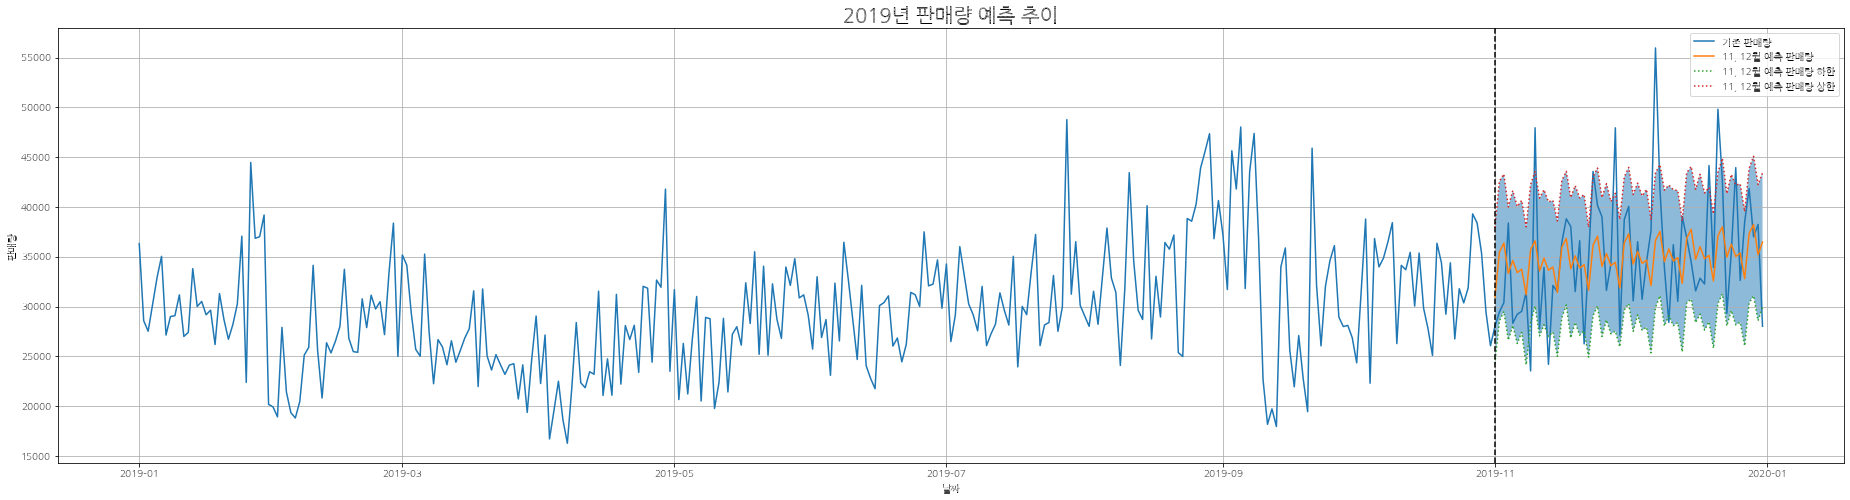

In [21]:
# 시각화
plt.figure(figsize=(32, 8))
plt.plot(daily['판매량'], label='기존 판매량')
plt.plot(daily['판매량_예측_pred'], label='11, 12월 예측 판매량')
plt.plot(daily['판매량_예측_lower'], linestyle='dotted', label='11, 12월 예측 판매량 하한')
plt.plot(daily['판매량_예측_upper'], linestyle='dotted', label='11, 12월 예측 판매량 상한')
plt.fill_between(daily.index, daily['판매량_예측_lower'], daily['판매량_예측_upper'], alpha=0.5)
plt.axvline(x=pd.to_datetime('2019-11-01'), linestyle='dashed', color='black')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.title('2019년 판매량 예측 추이', size=20)
plt.grid()
plt.legend()
plt.show()